# Spine Classification: A Complete PyTorch Pipeline

The goal of this notebook is to build a complete classification pipeline using PyTorch. We will train a simple neural network to predict whether a patient's spinal condition is "Abnormal" or "Normal" based on 6 biomechanical features.

This project covers the full Machine Learning Pipeline:
1. **Data Loading and preprocessing**
2. **Train-Test split**
3. **Feature scaling** (Z-Score Normalization)
4. **Model building** (Logistic model with PyTorch)
5. **Training**
6. **Evaluation** (Accuracy & Confusion matrix)

## 1. Setup: Imports and Seeding

First, we import all necessary libraries.

Most importantly, we set a global `seed` for `torch`, `numpy`, and `random`. This ensures that our results are **100% reproducible**.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import torch
import torch.nn as nn
import torch.optim as optim
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 2. Data loading and Conversion

In [45]:
data_spine = pd.read_csv('C:/Users/alexi/OneDrive/Bureau/Dataset_spine.csv', header=0, sep=',', decimal='.')
data_spine.head(10)

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,Abnormal
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,Abnormal
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,Abnormal
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,Abnormal
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,Abnormal


In [46]:
def convert_data(data_spine):
    data_converted = data_spine.iloc[:, 0:-1].values

    spine_result_bool = torch.tensor(data_spine['Class_att'] == 'Abnormal', dtype=torch.float32)
    spine_result = spine_result_bool.unsqueeze(1)
    
    Spine_data_train, Spine_data_test, Tensor_Spine_result_train, Tensor_Spine_result_test = train_test_split(
        data_converted, spine_result,
        test_size=0.2,
        stratify=spine_result,
        random_state=seed,
        shuffle=True)
    Tensor_Spine_data_train = torch.tensor(Spine_data_train, dtype=torch.float32)
    Tensor_Spine_data_test = torch.tensor(Spine_data_test, dtype=torch.float32)
    return Tensor_Spine_data_train, Tensor_Spine_data_test, Tensor_Spine_result_train, Tensor_Spine_result_test

X_train, X_test, y_train, y_test = convert_data(data_spine)

print(f"Training data shape (X): {X_train.shape}")
print(f"Test data shape (X): {X_test.shape}")
print(f"Training labels shape (y): {y_train.shape}")
print(f"Test labels shape (y): {y_test.shape}")


Training data shape (X): torch.Size([248, 6])
Test data shape (X): torch.Size([62, 6])
Training labels shape (y): torch.Size([248, 1])
Test labels shape (y): torch.Size([62, 1])


## 3. Feature Scaling (Z-Score Normalization)

To prevent **data leakage**, we compute the `mean` and `std` **only** from the `X_train` data and apply that transformation to both the train and test sets.

In [47]:
def normalize(data_train,data_test):
    mu,std=torch.mean(data_train,dim=0),torch.std(data_train,dim=0)
    data_train=(data_train-mu)/std
    data_test=(data_test-mu)/std
    return data_train,data_test
X_train,X_test=normalize(X_train,X_test)
print(f"Train data mean after normalization:\n {X_train.mean(dim=0)}")
print(f"Train data standard deviation after normalization:\n {X_train.std(dim=0)}")

Train data mean after normalization:
 tensor([ 2.1246e-07,  2.0765e-07, -1.9612e-07,  2.9514e-07, -1.9227e-09,
        -3.0764e-08])
Train data standard deviation after normalization:
 tensor([1., 1., 1., 1., 1., 1.])


## 4. Model Definition and Training

Here we define our model architecture and training loop.

### 4.1. Model Selection (Linear vs. Non-Linear)

I first experimented with a non-linear model using a `ReLU` activation function (`Linear(6,3) -> ReLU -> Linear(3,1)`). This is a common approach, but it resulted in a lower accuracy of ~83%.

I hypothesized that the problem was simpler and that the non-linearity was causing overfitting.

I therefore removed the `ReLU` activation. The final model is a **purely linear architecture**: `Linear(6,3) -> Linear(3,1)`. This simpler model was superior, achieving **88% accuracy**.

### 4.2. Loss Function

**Loss Function:** `BCEWithLogitsLoss`. This is the standard, numerically stable choice for binary classification, as it combines Sigmoid and BCELoss.

In [58]:
def logistic_model():
    torch.manual_seed(seed)
    model = nn.Sequential(
        nn.Linear(6, 3),
        # nn.ReLU(),  
        nn.Linear(3, 1)  
    )
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_function = nn.BCEWithLogitsLoss()
    return model, optimizer, loss_function

def learning(data_train,result_train,epochs):
    losses=[]
    model,optimizer,loss_function=logistic_model()
    for i in range(epochs):
        outputs=model(data_train)
        loss=loss_function(outputs,result_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return model,losses


## 5. Training the Model

Now, let's run the training process for 5000 epochs and visualize the loss curve.

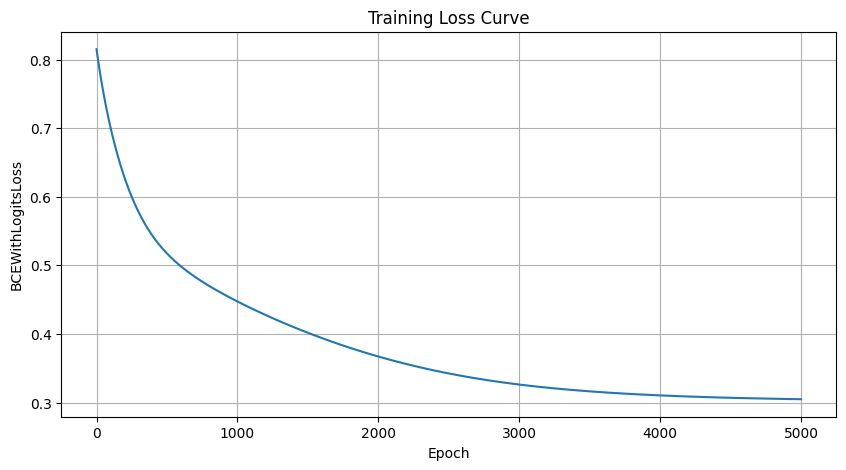

In [60]:
epochs = 5000
model, losses = learning(X_train, y_train, epochs)
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.grid()
plt.show()

## 6. Evaluation

The training is complete. Now we evaluate our model on the **unseen test data**.

-   `predict()` runs the model in `eval()` and `no_grad()` mode. It converts the raw `logits` to class predictions (`>= 0.0`).
-   `display()` uses Scikit-learn to plot a clear Confusion Matrix.

In [61]:
def predict(test_model,data_test,spine_result):   
    test_model.eval()
    with torch.no_grad():
        bool_outputs=test_model(data_test)>=0
        newmodel=bool_outputs.float()
    accuracy=100*sum(newmodel==spine_result)/spine_result.shape[0]
    return newmodel,accuracy

def display(prediction,result):
    newmodel_numpy=prediction.detach().numpy()
    Spine_result_test_numpy=result.detach().numpy()
    cm=confusion_matrix(Spine_result_test_numpy,newmodel_numpy)
    labels=['Normal(0)','Abnormal(1)']
    disp=ConfusionMatrixDisplay(cm,display_labels=labels)
    disp.plot()
    plt.show()

## 7. Final Results

Let's see our final accuracy and the confusion matrix on the test set.

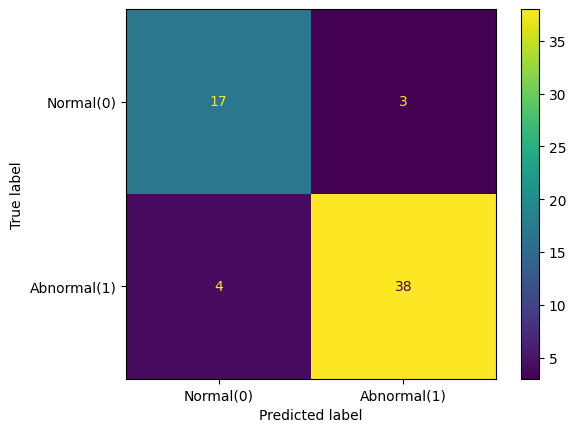

Our model is 88.71% accurate


In [62]:
def test_and_display():
    Spine_data_train,Spine_data_test,Spine_result_train,Spine_result_test=convert_data(data_spine)
    Spine_data_train, Spine_data_test = normalize(Spine_data_train, Spine_data_test)
    model=learning(Spine_data_train,Spine_result_train,5000)[0]
    newmodel,accuracy=predict(model,Spine_data_test,Spine_result_test)
    display(newmodel,Spine_result_test)
    return accuracy.item()

model_accuracy=test_and_display()
print(f"Our model is {model_accuracy:.2f}% accurate")
